In [1]:
import os
os.chdir('../../')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
### Load the data into dataframes

df_train = pd.read_csv('data/clean/clean_data_train.csv', index_col=False)
df_test = pd.read_csv('data/clean/clean_data_test.csv', index_col=False)

In [3]:
df_train.head()

,team1,team1score,team2,team2score,match_type,match_stage,player0_id,player0_rating,player0_kd,player1_id,...,player7_kd,player8_id,player8_rating,player8_kd,player9_id,player9_rating,player9_kd,team1_Ranking,team2_Ranking,team_1_won
0,FaZe,0,Spirit,3,BO5,GF,9960.0,1.16,1.14,11816.0,...,1.06,18317,1.07,1.04,7716.0,0.99,0.93,2.0,14.0,0
1,Spirit,2,Falcons,0,BO3,SF,21167.0,1.46,1.47,16920.0,...,1.05,11777,1.05,1.02,922.0,0.83,0.73,14.0,11.0,1
2,MOUZ,0,FaZe,2,BO3,SF,18850.0,1.13,1.23,13666.0,...,1.13,8183,1.11,1.02,429.0,0.94,0.83,5.0,2.0,0
3,ENCE,1,Falcons,2,BO3,QF,16848.0,1.20,1.36,19114.0,...,1.14,11777,1.07,1.05,922.0,0.86,0.76,48.0,11.0,0
4,FaZe,2,G2,0,BO3,QF,9960.0,1.16,1.17,11816.0,...,0.92,9618,0.96,0.89,10096.0,0.89,0.76,2.0,6.0,1


In [4]:
## Here we get the numerical features
numerical_features = ['team1_Ranking', 'team2_Ranking']
for i in range(10):
    numerical_features.append(f'player{i}_rating')
    numerical_features.append(f'player{i}_kd')


## Create train datasets out of the numerical features
X_train = df_train[numerical_features]
y_train = df_train['team_1_won']

## Create test datasets out of the numerical features
X_test = df_test[numerical_features]
y_test = df_test['team_1_won']

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV


accs = []

Cs = 2**np.linspace(-8, 3, 500) ## Defines our grid of hyperparameters
log_reg_model = LogisticRegression(max_iter=1000, solver='liblinear')
cv = GridSearchCV(log_reg_model, param_grid={'penalty': ['l1','l2'],'C': Cs}, cv=10) ## Searches through our grid for both 'l1' and 'l2' penalty
cv.fit(X_train, y_train) ## Fit the model to our data 

GridSearchCV(cv=10,
             estimator=LogisticRegression(max_iter=1000, solver='liblinear'),
             param_grid={'C': array([3.90625000e-03, 3.96639504e-03, 4.02746614e-03, 4.08947757e-03,
       4.15244378e-03, 4.21637950e-03, 4.28129965e-03, 4.34721938e-03,
       4.41415408e-03, 4.48211939e-03, 4.55113117e-03, 4.62120553e-03,
       4.69235883e-03, 4.76460769e-03, 4.83796898e-03, 4.91245982e-03,
       4.988...
       5.62941876e+00, 5.71609566e+00, 5.80410713e+00, 5.89347372e+00,
       5.98421631e+00, 6.07635607e+00, 6.16991452e+00, 6.26491350e+00,
       6.36137519e+00, 6.45932211e+00, 6.55877714e+00, 6.65976348e+00,
       6.76230473e+00, 6.86642482e+00, 6.97214806e+00, 7.07949913e+00,
       7.18850310e+00, 7.29918542e+00, 7.41157194e+00, 7.52568888e+00,
       7.64156289e+00, 7.75922103e+00, 7.87869077e+00, 8.00000000e+00]),
                         'penalty': ['l1', 'l2']})

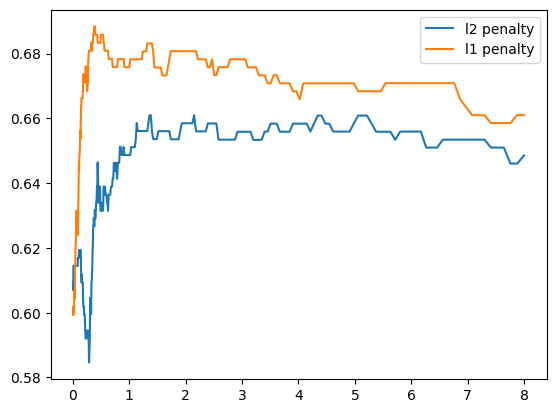

In [6]:
### Here we plot the CV scores for both penaltys for our Grid of Hyperparameters

plt.plot(Cs, cv.cv_results_['mean_test_score'][::2], label = 'l2 penalty')
plt.plot(Cs, cv.cv_results_['mean_test_score'][1::2], label = 'l1 penalty')
plt.legend()

In [7]:
from sklearn.metrics import log_loss

log_reg_best = cv.best_estimator_ ## Extracts the best model found

log_reg_best.fit(X_train, y_train) ## Fit using full Train data

## Now we make our predictions on the etst set
y_pred = log_reg_best.predict(X_test)
y_pred_proba = log_reg_best.predict_proba(X_test)

print('Accuracy is', np.mean(y_pred == y_test))

print('Cross entropy score is ', log_loss(y_test, y_pred_proba))



Accuracy is 0.7941176470588235
Cross entropy score is  0.539657786121049


['outputs/models/log_reg.pkl']

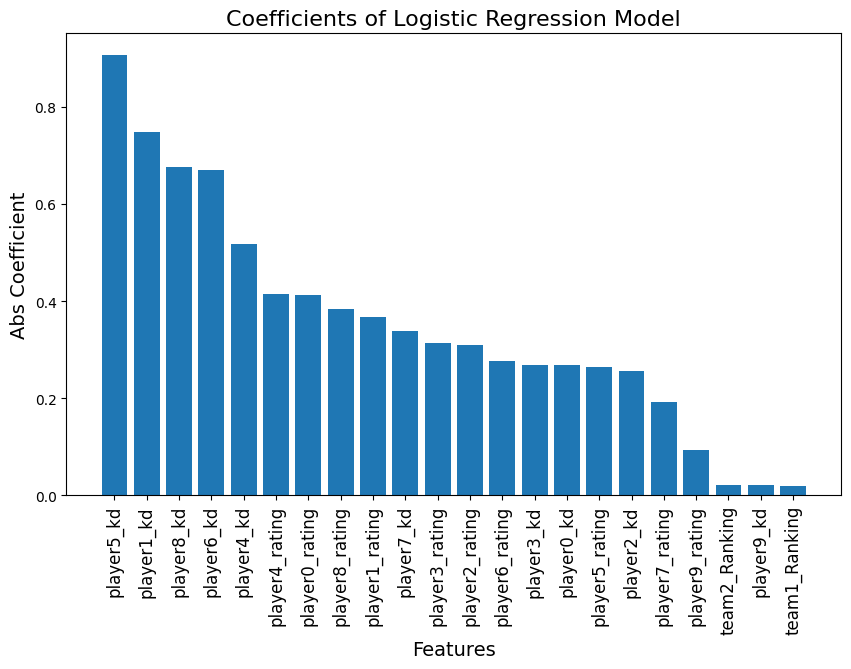

In [8]:
# Get coefficients and feature names
coefficients = abs(log_reg_best.coef_.squeeze())
feature_names = log_reg_best.feature_names_in_

# Sort coefficients and feature names in descending order
sorted_indices = coefficients.argsort()[::-1]
sorted_coefficients = coefficients[sorted_indices]
sorted_feature_names = [feature_names[i] for i in sorted_indices]

# Plot bar chart
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_coefficients)), sorted_coefficients)
plt.xlabel('Features', fontsize=14)
plt.ylabel('Abs Coefficient', fontsize=14)
plt.xticks(range(len(sorted_coefficients)), sorted_feature_names, rotation=90, fontsize=12)
plt.title('Coefficients of Logistic Regression Model', fontsize=16)
plt.show()

Text(0.5, 1.0, 'Permutation Importance of Features')

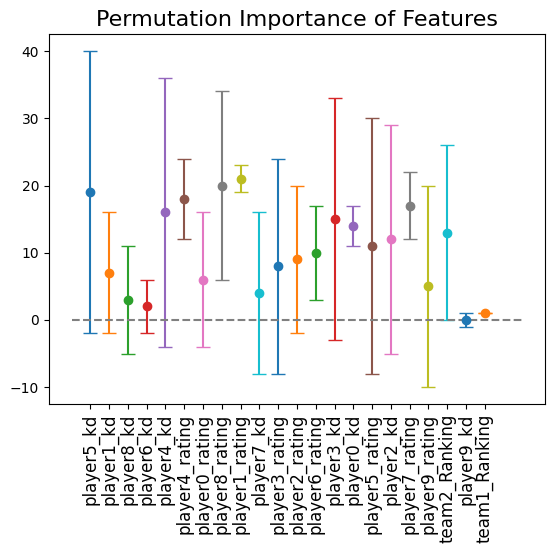

In [9]:
from sklearn.inspection import permutation_importance

r = permutation_importance(log_reg_best, X_test, y_test, n_repeats=30, random_state=42) ## Calculates the eprmutation importance of each feature

## Plot the importance and standard error bars for each feature
for i, mean in enumerate(r.importances_mean.argsort()):
    plt.errorbar(i, mean, yerr=r.importances_std.argsort()[i], fmt='o', capsize=5)

plt.xticks(range(len(sorted_coefficients)), sorted_feature_names, rotation=90, fontsize=12)
plt.hlines(0, -1, 23, linestyles='--', colors='grey')

plt.title('Permutation Importance of Features', fontsize=16)


    

# Feature Importance
The two plots above show different metrics to assess the importance of a feature. The first plot shows the absolute value of the regression coefficients which give a measure of how much the prediction is affected by changing that feature by a unit. The permutation importance plot shows how shuffling the features in a column affects the results of prediction. We can see that nearly all player statistics are important for the task of prediction, with one exception in 'player9_kd'.  We also see that 'team1_Ranking' appears unimportant. It is surprising to see that these features being unimportant is 'one-sided' since the team order should be irrelavent, and as far as I am aware, hltv.org has no special ordering to which they display the teams. It is concerning to see this one-sided affair and could indicate some bias in our model.

To try and combat the effects of ordering, we are going to repeat the above model fitting and feature importance analysis on a new training dataset. We will construct this dataset by randomly flipping the order of teams (and players) for each match. The code for this can be found below.

In [47]:
## Code for random flipped dataset
team_flip_train = df_train.copy()
team_flip_train['team1'], team_flip_train['team2'] = df_train['team2'], df_train['team1'] ## Flip teams around
team_flip_train['team1_Ranking'], team_flip_train['team2_Ranking'] = df_train['team2_Ranking'], df_train['team1_Ranking'] ## Flip team rankings

## Flip players
for i in range(5):
    team_flip_train[f'player{i}_rating'] = df_train[f'player{5+i}_rating']
    team_flip_train[f'player{i}_kd'] = df_train[f'player{5+i}_kd']

team_flip_train['team_1_won'] = 1 - df_train['team_1_won'] ## Flip the team who won

### Repeat above for test set
team_flip_test = df_test.copy()
team_flip_test['team1'], team_flip_test['team2'] = df_test['team2'], df_test['team1']
team_flip_test['team1_Ranking'], team_flip_test['team2_Ranking'] = df_test['team2_Ranking'], df_test['team1_Ranking']

for i in range(10):
    team_flip_test[f'player{i}_rating'] = df_test[f'player{i}_rating']
    team_flip_test[f'player{i}_kd'] = df_test[f'player{i}_kd']

team_flip_test['team_1_won'] = 1 - df_test['team_1_won']



X_flip_train = team_flip_train[numerical_features] ## Get numerical features
y_flip_train = team_flip_train['team_1_won']

In [48]:
'''
In this cell we create a new train dataset by randomly flipping the teams around with probability 0.5
We do this by creating a mask of 0, 1's with 1 meaning a flip
'''

n = len(X_train)
np.random.seed(42)
mask = np.random.randint(0,2,n) ## Random mask 
X_rnd_flip = pd.concat((X_train[mask==0], X_flip_train[mask==1]))
y_rnd_flip = pd.concat((y_train[mask==0], y_flip_train[mask==1]))

In [65]:
## CV grid search as before

accs = []

Cs = 2**np.linspace(-8, 3, 500)
log_reg_model = LogisticRegression(max_iter=1000, solver='liblinear')
cv = GridSearchCV(log_reg_model, param_grid={'penalty': ['l1','l2'],'C': Cs}, cv=10)
cv.fit(X_rnd_flip, y_rnd_flip)

GridSearchCV(cv=10,
             estimator=LogisticRegression(max_iter=1000, solver='liblinear'),
             param_grid={'C': array([3.90625000e-03, 3.96639504e-03, 4.02746614e-03, 4.08947757e-03,
       4.15244378e-03, 4.21637950e-03, 4.28129965e-03, 4.34721938e-03,
       4.41415408e-03, 4.48211939e-03, 4.55113117e-03, 4.62120553e-03,
       4.69235883e-03, 4.76460769e-03, 4.83796898e-03, 4.91245982e-03,
       4.988...
       5.62941876e+00, 5.71609566e+00, 5.80410713e+00, 5.89347372e+00,
       5.98421631e+00, 6.07635607e+00, 6.16991452e+00, 6.26491350e+00,
       6.36137519e+00, 6.45932211e+00, 6.55877714e+00, 6.65976348e+00,
       6.76230473e+00, 6.86642482e+00, 6.97214806e+00, 7.07949913e+00,
       7.18850310e+00, 7.29918542e+00, 7.41157194e+00, 7.52568888e+00,
       7.64156289e+00, 7.75922103e+00, 7.87869077e+00, 8.00000000e+00]),
                         'penalty': ['l1', 'l2']})

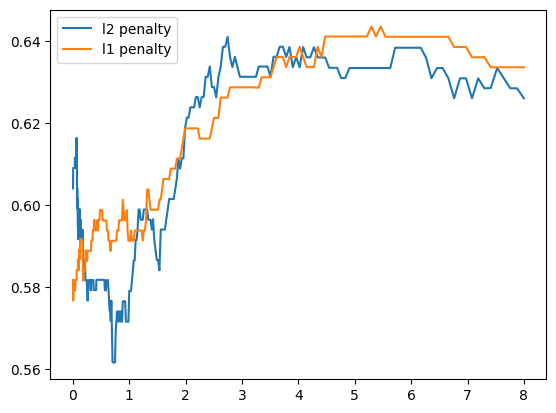

In [66]:
## Plot CV scores
plt.plot(Cs, cv.cv_results_['mean_test_score'][::2], label = 'l2 penalty')
plt.plot(Cs, cv.cv_results_['mean_test_score'][1::2], label = 'l1 penalty')
plt.legend()

In [67]:
log_reg_flip_best = cv.best_estimator_ ## Gets best model found

log_reg_flip_best.fit(X_rnd_flip, y_rnd_flip) ## Fit on full random flip train dataset

# make our predictions on test set
y_pred = log_reg_flip_best.predict(X_test)
y_pred_proba = log_reg_flip_best.predict_proba(X_test)

print('Accuracy is', np.mean(y_pred == y_test))

print('Cross entropy score is ', log_loss(y_test, y_pred_proba))


import joblib

# Save the model to a file
joblib.dump(log_reg_flip_best, 'outputs/models/log_reg.pkl')


Accuracy is 0.8235294117647058
Cross entropy score is  0.5441652297796646


['outputs/models/log_reg.pkl']

Here we can see that the accuracy and cross entropy scores have improved with this model. So we will save this model to use as our logistic regression model for prediction.

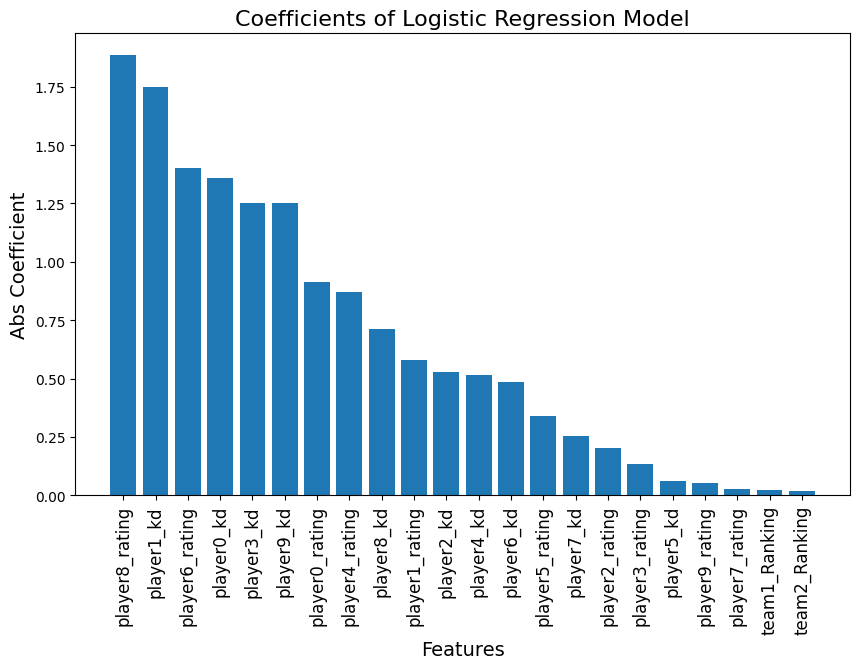

In [56]:
# Get coefficients and feature names
coefficients = abs(log_reg_flip_best.coef_.squeeze())
feature_names = log_reg_flip_best.feature_names_in_

# Sort coefficients and feature names in descending order
sorted_indices = coefficients.argsort()[::-1]
sorted_coefficients = coefficients[sorted_indices]
sorted_feature_names = [feature_names[i] for i in sorted_indices]

# Plot bar chart
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_coefficients)), sorted_coefficients)
plt.xlabel('Features', fontsize=14)
plt.ylabel('Abs Coefficient', fontsize=14)
plt.xticks(range(len(sorted_coefficients)), sorted_feature_names, rotation=90, fontsize=12)
plt.title('Coefficients of Logistic Regression Model', fontsize=16)
plt.show()

Text(0.5, 1.0, 'Permutation Importance of Features')

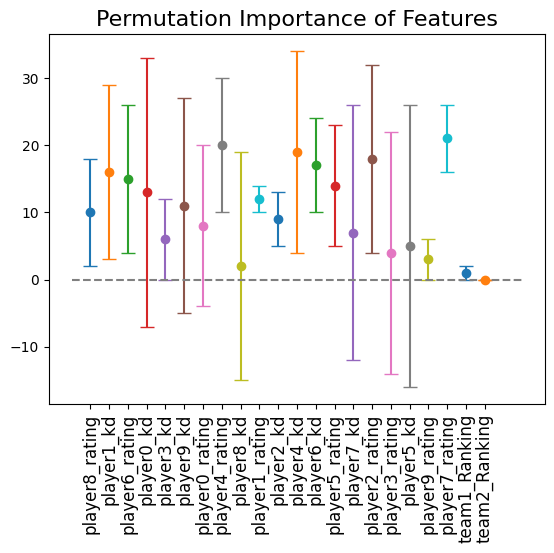

In [57]:
## Gather and plot the feature importance scores as before

r = permutation_importance(log_reg_flip_best, X_test, y_test, n_repeats=30, random_state=42)

for i, mean in enumerate(r.importances_mean.argsort()):
    plt.errorbar(i, mean, yerr=r.importances_std.argsort()[i], fmt='o', capsize=5)

plt.xticks(range(len(sorted_coefficients)), sorted_feature_names, rotation=90, fontsize=12)
plt.hlines(0, -1, 23, linestyles='--', colors='grey')

plt.title('Permutation Importance of Features', fontsize=16)



These plots now suggest that all player statistics are important, but team rankings appear unimportant. This 'importance' is now symmetric by team which signifies that we have improved our model and removed some bias by using our 'random flipped' dataset. We do see that coefficients are not symmetric, and we may belive they should have the same order of magnitude, but we have a small dataset, so we should expect some deviation. In fact, you could enforce this relationship by using a player kd and rating difference as your features. I believe that the player statistics are likely to be acting as a proxy for the team rankings, thus rendering them unimportant; since the rankings on there own do a good job of prediction.